In [1]:
#include "ROOT/RDataFrame.hxx"
#include "ROOT/RVec.hxx"
#include <ROOT/RLogger.hxx>
#include "TCanvas.h"
#include "TFile.h"
#include "TH1D.h"
#include "TLegend.h"
//cpp
#include <vector>
#include <iostream>
#include <cstdlib>
#include <cstdio>
#include <string>
#include <Math/GenVector/LorentzVector.h>
#include <Math/GenVector/PtEtaPhiM4D.h>
#include <stdlib.h>
#include <math.h>
#include <TH1.h>

template <typename T> using Vec = ROOT::RVec<T>; 

class RecoTriplet_class{
    public: 
        RecoTriplet_class(bool ReturnGenIdx) :
            ReturnGenIdx_(ReturnGenIdx) {}

        Vec<size_t> operator()(Vec<float> gen_pt, Vec<float> gen_eta, Vec<float> gen_phi, Vec<int> gen_charge,
                 Vec<float> puppi_pt, Vec<float> puppi_eta, Vec<float> puppi_phi, Vec<int> puppi_charge, Vec<int> puppi_pdg) const {
            
            Vec<int> puppi_pdg_idx;
            Vec<size_t> PG_idx;
            Vec<size_t> G_idx;
            //          PGD             //
            for(int i = 0; i < puppi_pdg.size(); ++i) { //make list of pions or electron
                if (abs(puppi_pdg[i]) == 211 || abs(puppi_pdg[i]) == 11) puppi_pdg_idx.push_back(i);
                // puppi_pdg_idx.push_back(i);
            }
            for(std::size_t i=0; i<gen_pt.size(); i++){
                float DRmin = 0.1; int index = -1;
                for(size_t j : puppi_pdg_idx){
                    if (puppi_pt[j] <= gen_pt[i]/2 || puppi_pt[j] >= 2*gen_pt[i]) continue;
                    float DR = ROOT::VecOps::DeltaR(gen_eta[i], puppi_eta[j], gen_phi[i], puppi_phi[j]);
                    if (DR < DRmin) {
                        DRmin = DR;
                        index = j;
                    }
                }
                if (index != -1) {
                    PG_idx.push_back(index);
                    G_idx.push_back(i);
                }
            }
            
            if(PG_idx.size()==3){
                if(ReturnGenIdx_) return G_idx;
                else return PG_idx;
            }
            else{
                return {};
            }

        }

    private: 
        bool ReturnGenIdx_;

};

class Resolution{
    public:
        Resolution(bool Normalize=true) :
            Normalize_(Normalize) {}
        Vec<float> operator()(Vec<float> reco_pt, Vec<float> gen_pt,Vec<int> reco_charge, Vec<int> gen_charge) const {
            Vec<float> resolution;
            for(int i=0; i<gen_pt.size();i++){
                if(Normalize_) resolution.push_back((gen_pt[i] - reco_pt[i]) / gen_pt[i] );
                else resolution.push_back((gen_pt[i] - reco_pt[i]));

                // if(Normalize_) resolution.push_back((gen_charge[i]/gen_pt[i] - reco_charge[i]/reco_pt[i]) * gen_pt[i]/gen_charge[i]);
                // else resolution.push_back(gen_charge[i]/gen_pt[i] - reco_charge[i]/reco_pt[i]);
            }
            return resolution;
        }

    private:
        bool Normalize_;
};

bool notempty(Vec<std::size_t> index) { //used to check if any triplets passed in an event
    return !index.empty();
}


class PtEtaSelection{
    public:
        PtEtaSelection(float ptMin, float ptMax, float etaLim, bool etaless=true) : //etaless=true means it will take |eta|<etaLim
            ptMin_(ptMin), ptMax_(ptMax), etaLim_(etaLim), etaless_(etaless) {}

        Vec<size_t> operator()(Vec<float> &gen_pt, Vec<float> &gen_eta) const{
            Vec<int> idx;
            for(int i=0;i<gen_eta.size();i++){
                if(etaless_){
                    if(abs(gen_eta[i])< etaLim_ && (gen_pt[i] > ptMin_ && gen_pt[i] < ptMax_))  //passing eta filter and pt filter interval
                    idx.push_back(i);
                }
                else{
                    if(abs(gen_eta[i])> etaLim_ && (gen_pt[i] > ptMin_ && gen_pt[i] < ptMax_))  //passing eta filter and pt filter interval
                    idx.push_back(i);
                }
            }
            return idx;
        }
    private:
        float ptMin_, ptMax_, etaLim_;
        bool etaless_;
};

In [2]:
float MassResolution(ROOT::VecOps::RVec<float> gen_pt,
            ROOT::VecOps::RVec<float> gen_eta, 
            ROOT::VecOps::RVec<float> gen_phi, 
            ROOT::VecOps::RVec<float> gen_mass,
            ROOT::VecOps::RVec<float> reco_pt,
            ROOT::VecOps::RVec<float> reco_eta, 
            ROOT::VecOps::RVec<float> reco_phi, 
            ROOT::VecOps::RVec<float> reco_mass){

    float gen_invmass  = ROOT::VecOps::InvariantMass(gen_pt, gen_eta, gen_phi, gen_mass);
    float reco_invmass = ROOT::VecOps::InvariantMass(reco_pt, reco_eta, reco_phi, reco_mass);

    // return ((gen_invmass - reco_invmass)) ;
    return ((gen_invmass - reco_invmass)/gen_invmass) ;
}

In [3]:
auto file_path = "l1Nano_WTo3Pion_PU200_iso.root";
auto tree_name = "Events";

ROOT::RDataFrame df(tree_name,file_path);

In [4]:
auto df1 = df.Define("idx", PtEtaSelection(0.,200.,2.4), {"GenPi_pt","GenPi_eta"})
            .Define("gen_pt",     "Take(GenPi_pt,  idx)")
            .Define("gen_eta",    "Take(GenPi_eta, idx)")
            .Define("gen_phi",    "Take(GenPi_phi, idx)")
            .Define("gen_mass",   "Take(GenPi_mass, idx)")
            .Define("gen_charge", "Take(GenPi_charge, idx)")
            .Define("RecoPuppi_idx", RecoTriplet_class(false), {"gen_pt", "gen_eta", "gen_phi", "gen_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
            .Define("RecoGen_idx",   RecoTriplet_class(true),  {"gen_pt", "gen_eta", "gen_phi", "gen_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
            .Filter(notempty, {"RecoGen_idx"})
            .Define("Reco_pt", "Take(L1Puppi_pt, RecoPuppi_idx)")
            .Define("Gen_pt",  "Take(gen_pt, RecoGen_idx)")
            .Define("Reco_eta", "Take(L1Puppi_eta, RecoPuppi_idx)")
            .Define("Gen_eta",  "Take(gen_eta, RecoGen_idx)")
            .Define("Reco_phi", "Take(L1Puppi_phi, RecoPuppi_idx)")
            .Define("Gen_phi",  "Take(gen_phi, RecoGen_idx)")
            .Define("Reco_mass", "Take(L1Puppi_mass, RecoPuppi_idx)")
            .Define("Gen_mass",  "Take(gen_mass, RecoGen_idx)")
            // .Define("Reco_charge", "Take(L1Puppi_charge, RecoPuppi_idx)")
            // .Define("Gen_charge",  "Take(gen_charge, RecoGen_idx)")
            .Define("mass_res", MassResolution, {"Gen_pt", "Gen_eta", "Gen_phi", "Gen_mass","Reco_pt", "Reco_eta", "Reco_phi", "Reco_mass"});


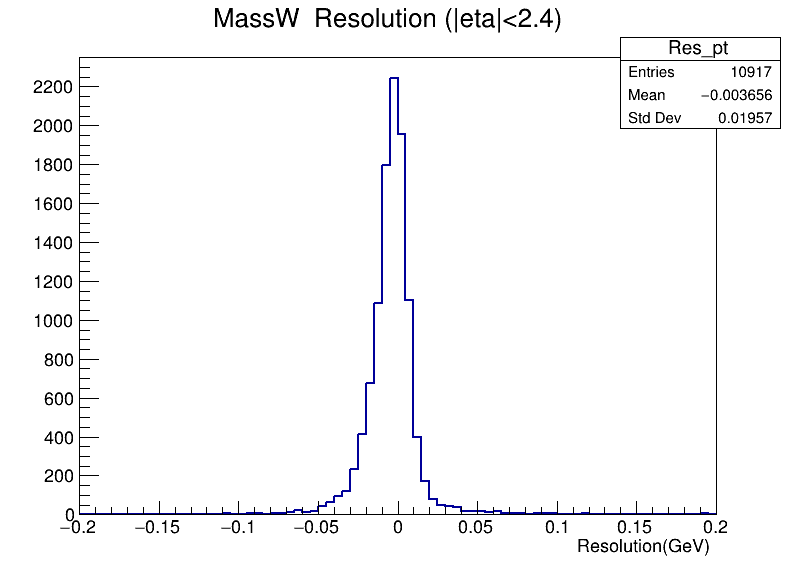

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [6]:
auto hist_mass = df1.Histo1D({"Res_pt", "MassW  Resolution (|eta|<2.4) ;Resolution(GeV)", 80, -0.2, 0.2}, "mass_res");
auto c1 = new TCanvas("c1", "c1", 800,600);

hist_mass -> SetLineWidth(2);
// hist_ptres -> SetLineColor();

hist_mass -> Draw();
c1 -> Draw();

In [12]:
auto m = df1.Take<ROOT::VecOps::RVec<float>>("Gen_mass").GetValue();

cout <<"gen pt"<< m[1] << endl;

input_line_62:2:15: error: use 'template' keyword to treat 'Take' as a dependent template name
 auto m = df1.Take<ROOT::VecOps::RVec<float>>("Gen_mass").GetValue();
              ^
              template 
input_line_62:2:2: error: Syntax error
 auto m = df1.Take<ROOT::VecOps::RVec<float>>("Gen_mass").GetValue();
 ^
FunctionDecl 0x7f9b90eae238 <input_line_62:1:1, line:6:1> line:1:6 __cling_Un1Qu325 'void (void *)'
|-ParmVarDecl 0x7f9b90eae180 <col:23, col:29> col:29 vpClingValue 'void *'
|-CompoundStmt 0x7f9b90eb8d48 <col:43, line:6:1>
| |-DeclStmt 0x7f9b90eae7f8 <line:2:2, col:69>
| | `-VarDecl 0x7f9b90eae340 <col:2, col:68> col:7 used m 'auto' cinit
| |   `-CallExpr 0x7f9b90eae7d8 <col:11, col:68> '<dependent type>'
| |     `-CXXDependentScopeMemberExpr 0x7f9b90eae790 <col:11, col:59> '<dependent type>' lvalue .GetValue
| |       `-CallExpr 0x7f9b90eae768 <col:11, col:57> '<dependent type>'
| |         |-CXXDependentScopeMemberExpr 0x7f9b90eae6d0 <col:11, col:45> '<dependent type>' lv

In [13]:
int ev=1;
auto ii = df1.Take<ROOT::VecOps::RVec<unsigned long>>("RecoPuppi_idx").GetValue();
auto ig = df1.Take<ROOT::VecOps::RVec<unsigned long>>("RecoGen_idx").GetValue();
cout <<"pup idx"<< ii[ev] << endl;
cout <<"gen idx"<< ig[ev] << endl;

auto m = df1.Take<ROOT::VecOps::RVec<float>>("gen_mass").GetValue();
// auto cc = df1.Take<ROOT::VecOps::RVec<int>>("Gen_charge").GetValue();

cout <<"gen pt"<< m[ev] << endl;
// cout <<"gen charge"<< cc[ev] << endl;

input_line_63:3:15: error: use 'template' keyword to treat 'Take' as a dependent template name
auto ii = df1.Take<ROOT::VecOps::RVec<unsigned long>>("RecoPuppi_idx").GetValue();
              ^
              template 
input_line_63:4:11: error: use of undeclared identifier 'df1'
auto ig = df1.Take<ROOT::VecOps::RVec<unsigned long>>("RecoGen_idx").GetValue();
          ^
input_line_63:8:10: error: use of undeclared identifier 'df1'
auto m = df1.Take<ROOT::VecOps::RVec<float>>("gen_mass").GetValue();
         ^
input_line_63:3:1: error: Syntax error
auto ii = df1.Take<ROOT::VecOps::RVec<unsigned long>>("RecoPuppi_idx").GetValue();
^
FunctionDecl 0x7f9b90eb8e78 <input_line_63:1:1, line:14:1> line:1:6 __cling_Un1Qu326 'void (void *)'
|-ParmVarDecl 0x7f9b90eb8dc0 <col:23, col:29> col:29 vpClingValue 'void *'
|-CompoundStmt 0x7f9b90ebe3e8 <col:43, line:14:1>
| |-DeclStmt 0x7f9b90eb9008 <line:2:2, col:10>
| | `-VarDecl 0x7f9b90eb8f60 <col:2, col:9> col:6 used ev 'int' cinit
| |   `-IntegerLit

In [14]:
auto Gpt  = df1.Take<ROOT::VecOps::RVec<float>>("Gen_pt").GetValue()  [ev];
auto Geta = df1.Take<ROOT::VecOps::RVec<float>>("Gen_eta").GetValue() [ev];
auto Gphi = df1.Take<ROOT::VecOps::RVec<float>>("Gen_phi").GetValue() [ev];
auto Gm   = df1.Take<ROOT::VecOps::RVec<float>>("Gen_mass").GetValue()[ev];

auto Rpt  = df1.Take<ROOT::VecOps::RVec<float>>("Reco_pt").GetValue()  [ev];
auto Reta = df1.Take<ROOT::VecOps::RVec<float>>("Reco_eta").GetValue() [ev];
auto Rphi = df1.Take<ROOT::VecOps::RVec<float>>("Reco_phi").GetValue() [ev];
auto Rm   = df1.Take<ROOT::VecOps::RVec<float>>("Reco_mass").GetValue()[ev];

cout << MassResolution(Gpt,Geta,Gphi,Gm, Rpt,Reta,Rphi,Rm) << endl;
float gen_invmass  = ROOT::VecOps::InvariantMass(Gpt, Geta, Gphi, Gm);
float reco_invmass = ROOT::VecOps::InvariantMass(Rpt, Reta, Rphi, Rm);

// cout << ((gen_invmass - reco_invmass)/gen_invmass) ;


input_line_64:2:18: error: use 'template' keyword to treat 'Take' as a dependent template name
 auto Gpt  = df1.Take<ROOT::VecOps::RVec<float>>("Gen_pt").GetValue()  [ev];
                 ^
                 template 
input_line_64:2:73: error: use of undeclared identifier 'ev'
 auto Gpt  = df1.Take<ROOT::VecOps::RVec<float>>("Gen_pt").GetValue()  [ev];
                                                                        ^
input_line_64:3:13: error: use of undeclared identifier 'df1'
auto Geta = df1.Take<ROOT::VecOps::RVec<float>>("Gen_eta").GetValue() [ev];
            ^
input_line_64:3:72: error: use of undeclared identifier 'ev'
auto Geta = df1.Take<ROOT::VecOps::RVec<float>>("Gen_eta").GetValue() [ev];
                                                                       ^
input_line_64:4:13: error: use of undeclared identifier 'df1'
auto Gphi = df1.Take<ROOT::VecOps::RVec<float>>("Gen_phi").GetValue() [ev];
            ^
input_line_64:4:72: error: use of undeclared identifier 

In [15]:
auto m  = df1.Take<float>("mass_res").GetValue();
m[1]

input_line_65:2:16: error: use 'template' keyword to treat 'Take' as a dependent template name
 auto m  = df1.Take<float>("mass_res").GetValue();
               ^
               template 
input_line_65:2:2: error: Syntax error
 auto m  = df1.Take<float>("mass_res").GetValue();
 ^
FunctionDecl 0x7f9b90ebff88 <input_line_65:1:1, line:5:1> line:1:6 __cling_Un1Qu328 'void (void *)'
|-ParmVarDecl 0x7f9b90ebfed0 <col:23, col:29> col:29 vpClingValue 'void *'
|-CompoundStmt 0x7f9b90ec04d8 <col:43, line:5:1>
| |-DeclStmt 0x7f9b90ec0440 <line:2:2, col:50>
| | `-VarDecl 0x7f9b90ec0090 <col:2, col:49> col:7 used m 'auto' cinit
| |   `-CallExpr 0x7f9b90ec0420 <col:12, col:49> '<dependent type>'
| |     `-CXXDependentScopeMemberExpr 0x7f9b90ec03d8 <col:12, col:40> '<dependent type>' lvalue .GetValue
| |       `-CallExpr 0x7f9b90ec03b0 <col:12, col:38> '<dependent type>'
| |         |-CXXDependentScopeMemberExpr 0x7f9b90ec0318 <col:12, col:26> '<dependent type>' lvalue .Take
| |         | `-DeclRefEx

In [16]:
auto df2 = df.Define("RecoPuppi_idx", RecoTriplet_class(false), {"GenPi_pt", "GenPi_eta", "GenPi_phi", "GenPi_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
            .Define("RecoGen_idx",   RecoTriplet_class(true),   {"GenPi_pt", "GenPi_eta", "GenPi_phi", "GenPi_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
            .Filter(notempty, {"RecoGen_idx"})
            .Define("Reco_pt", "Take(L1Puppi_pt, RecoPuppi_idx)")
            .Define("Gen_pt",  "Take(GenPi_pt, RecoGen_idx)")
            .Define("Reco_eta", "Take(L1Puppi_eta, RecoPuppi_idx)")
            .Define("Gen_eta",  "Take(GenPi_eta, RecoGen_idx)")
            .Define("Reco_phi", "Take(L1Puppi_phi, RecoPuppi_idx)")
            .Define("Gen_phi",  "Take(GenPi_phi, RecoGen_idx)")
            .Define("Reco_mass", "Take(L1Puppi_mass, RecoPuppi_idx)")
            .Define("Gen_mass",  "Take(GenPi_mass, RecoGen_idx)")
            // .Define("Reco_charge", "Take(L1Puppi_charge, RecoPuppi_idx)")
            // .Define("Gen_charge",  "Take(gen_charge, RecoGen_idx)")
            .Define("mass_res", MassResolution, {"Gen_pt", "Gen_eta", "Gen_phi", "Gen_mass","Reco_pt", "Reco_eta", "Reco_phi", "Reco_mass"});


auto hist_mass2 = df2.Histo1D({"Res_pt", "MassW  Resolution ;Resolution(GeV)", 80, -5, 5}, "mass_res");
auto c1 = new TCanvas("c1", "c1", 800,600);

hist_mass2 -> SetLineWidth(2);
// hist_ptres -> SetLineColor();

hist_mass2 -> Draw();
c1 -> Draw();

In module 'ROOTDataFrame':
/home/pietro/anaconda3/envs/root-env/include/ROOT/RDF/RInterface.hxx:331:14: error: no matching member function for call to 'DefineImpl'
      return DefineImpl<F, RDFDetail::ExtraArgsForDefine::None>(name, std::move(expression), columns, "Define");
             ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
input_line_66:2:16: note: in instantiation of function template specialization 'ROOT::RDF::RInterface<ROOT::Detail::RDF::RLoopManager, void>::Define<RecoTriplet_class, 0>' requested here
 auto df2 = df.Define("RecoPuppi_idx", RecoTriplet_class(false), {"GenPi_pt", "GenPi_eta", "GenPi_phi", "GenPi_charge", "L1Puppi_pt", "L1Puppi_eta", "L1Puppi_phi", "L1Puppi_charge", "L1Puppi_pdgId"})
               ^
/home/pietro/anaconda3/envs/root-env/include/ROOT/RDF/RInterface.hxx:2717:4: note: candidate template ignored: substitution failure [with F = RecoTriplet_class, DefineType = ROOT::Detail::RDF::ExtraArgsForDefine::None, RetType = ROOT::VecOps::RVec<unsigne